# Model-Based: Бенчмарк оптимизированной реализации

**Цель:** Максимальное ускорение без изменения зависимостей (Фаза 1 из `.ai/PARALLEL_OPTIMIZATION_FEASIBILITY.md`).

### Применённые оптимизации

| Оптимизация | Expected Speedup | Описание |
|---|---|---|
| **LSODA вместо BDF** | ~12x ODE | Автовыбор stiff/non-stiff, быстрее BDF при <2% MSE deviation |
| **Deadline timeout (inline)** | ~50мс → ~0мс | `time.perf_counter()` вместо `threading.Thread` |
| **Numba JIT для ode_function** | ~100x ODE call | `@njit(cache=True, fastmath=True)` |
| **Configurable rtol/atol** | ~3–5x при rtol=1e-2 | Relaxed tolerances для exploration |
| **workers=-1** | ~Nx (N=cpu_count) | Параллельная оценка популяции DE |

**Суммарный ожидаемый speedup:** ~50–200x

### Схема реакций

$$ A \xrightarrow{k_1} B \xrightarrow{k_2} C \xrightarrow{k_3} D $$

### Вектор параметров ($M$ реакций)

$$ \text{params} = [\log A_1, \ldots, \log A_M,\; E_{a1}, \ldots, E_{aM},\; \text{model}_1, \ldots, \text{model}_M,\; \text{contrib}_1, \ldots, \text{contrib}_M] $$

### Целевая функция

$$ \text{MSE}_{\text{total}} = \sum_{\beta} \text{mean}\left((M_{\text{exp}}^{(\beta)} - M_{\text{model}}^{(\beta)})^2\right) $$

In [1]:
# === 1. Загрузка данных ===
import numpy as np
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path("c:/IDE/repository/solid-state_kinetics")

betas = [3.0, 5.0, 10.0]
file_paths = [
    PROJECT_ROOT / "resources/NH4_rate_3.csv",
    PROJECT_ROOT / "resources/NH4_rate_5.csv",
    PROJECT_ROOT / "resources/NH4_rate_10.csv",
]

dataframes = []
for path in file_paths:
    df_temp = pd.read_csv(path, delimiter=",")
    print(f"  {path.name}: {len(df_temp)} строк, столбцы: {list(df_temp.columns)}")
    dataframes.append(df_temp)

exp_temperature = dataframes[0]["temperature"].values + 273.15  # K
all_exp_masses = [
    dataframes[0]["rate_3"].values / 100.0,
    dataframes[1]["rate_5"].values / 100.0,
    dataframes[2]["rate_10"].values / 100.0,
]

print(f"\nТемпературы: {exp_temperature[0]:.1f} – {exp_temperature[-1]:.1f} K")
print(f"Массы β=3: {all_exp_masses[0][0]:.3f} → {all_exp_masses[0][-1]:.3f}")

  NH4_rate_3.csv: 490 строк, столбцы: ['temperature', 'rate_3']
  NH4_rate_5.csv: 490 строк, столбцы: ['temperature', 'rate_5']
  NH4_rate_10.csv: 490 строк, столбцы: ['temperature', 'rate_10']

Температуры: 304.4 – 771.3 K
Массы β=3: 0.995 → -0.004


In [2]:
# === 2. Схема реакций A→B→C→D и границы оптимизации ===

MODEL_NAMES = ["A2/3", "A3", "A3/2", "F1/3", "F1/A1", "F2", "F3", "G1", "G2", "R2", "R3"]

# Схема: A→B→C→D (3 реакции, 4 компонента)
src_indices = np.array([0, 1, 2], dtype=np.int64)  # A, B, C
tgt_indices = np.array([1, 2, 3], dtype=np.int64)  # B, C, D
num_species = 4
num_reactions = 3

# Границы: [logA_1..3, Ea_1..3, model_1..3, contrib_1..3]
bounds_list = []
for i in range(num_reactions):
    bounds_list.append((-15.0, 30.0))    # logA
for i in range(num_reactions):
    ea_max = 200.0 if i == 0 else 250.0
    bounds_list.append((30.0, ea_max))   # Ea (кДж/моль)
for i in range(num_reactions):
    bounds_list.append((0.0, 10.0))      # model index (0..10)
for i in range(num_reactions):
    bounds_list.append((0.01, 1.0))      # contribution

print(f"Компонентов: {num_species}, Реакций: {num_reactions}")
print(f"Параметров: {len(bounds_list)} ({num_reactions}×4: logA, Ea, model, contrib)")
print(f"Моделей: {MODEL_NAMES}")

Компонентов: 4, Реакций: 3
Параметров: 12 (3×4: logA, Ea, model, contrib)
Моделей: ['A2/3', 'A3', 'A3/2', 'F1/3', 'F1/A1', 'F2', 'F3', 'G1', 'G2', 'R2', 'R3']


In [3]:
# === 3. Импорт оптимизированных Numba-функций из pygmo_udp.py ===
import sys
import time

# pygmo_udp.py лежит в том же каталоге
sys.path.insert(0, str(PROJECT_ROOT / "docs" / "ru"))
from pygmo_udp import ode_function_numba, model_f_e, compute_ode_mse

# Warmup Numba JIT (первый вызов компилирует — не входит в бенчмарк)
print("Numba JIT warmup...")
t0 = time.perf_counter()
_ = model_f_e(0, 0.5)
_ = ode_function_numba(
    500.0,
    np.zeros(num_species + num_reactions),
    3.0,
    np.array([8.0]*3 + [120.0]*3 + [5.0]*3 + [0.5]*3),
    src_indices, tgt_indices, num_species, num_reactions,
)
warmup_time = time.perf_counter() - t0
print(f"Warmup завершён: {warmup_time:.2f} с")

Numba JIT warmup...
Warmup завершён: 0.52 с


In [4]:
# === 4. Picklable objective для workers=-1 ===
# На Windows multiprocessing использует 'spawn': worker-процессы не могут
# импортировать функции из __main__ (Jupyter notebook) → deadlock.
# SciPyObjective определён в pygmo_udp.py (нормальный .py модуль),
# поэтому workers могут его pickle/unpickle.

from scipy.optimize import differential_evolution
from pygmo_udp import SciPyObjective

SOLVER_METHOD = "LSODA"
SOLVER_RTOL = 1e-2
SOLVER_ATOL = 1e-4
TIMEOUT_MS = 200.0

objective = SciPyObjective(
    betas=betas,
    exp_temperature=exp_temperature,
    all_exp_masses=all_exp_masses,
    src_indices=src_indices,
    tgt_indices=tgt_indices,
    num_species=num_species,
    num_reactions=num_reactions,
    solver_method=SOLVER_METHOD,
    solver_rtol=SOLVER_RTOL,
    solver_atol=SOLVER_ATOL,
    timeout_ms=TIMEOUT_MS,
)

# Проверка: один вызов objective с начальными параметрами
x0 = [8.0]*3 + [120.0]*3 + [5.0]*3 + [0.5]*3
t0 = time.perf_counter()
mse0 = objective(x0)
t_single = time.perf_counter() - t0
print(f"Один вызов objective: MSE={mse0:.6f}, время={t_single*1000:.1f} мс")

# Проверка picklability (должно пройти без ошибок)
import pickle
_ = pickle.dumps(objective)
print("pickle.dumps(objective): OK ✓")

Один вызов objective: MSE=0.036280, время=6.6 мс
pickle.dumps(objective): OK ✓


In [5]:
# === 5. БЕНЧМАРК: differential_evolution с workers=-1 ===
import os

n_cpus = os.cpu_count()
print(f"CPU cores: {n_cpus}")
print(f"workers=-1 → использовать все {n_cpus} ядер")
print(f"Solver: {SOLVER_METHOD}, rtol={SOLVER_RTOL}, atol={SOLVER_ATOL}")
print(f"Параметров: {len(bounds_list)}, maxiter=1000, popsize=50")
print(f"\nЗапуск оптимизации...")
print("=" * 60)

t_start = time.perf_counter()

result = differential_evolution(
    objective,  # SciPyObjective — picklable, workers могут его использовать
    bounds=bounds_list,
    strategy="best1bin",
    maxiter=1000,
    popsize=50,
    tol=1e-3,
    mutation=(0.4, 1.2),
    recombination=0.7,
    seed=42,
    init="latinhypercube",
    workers=-1,
    polish=False,
    updating="deferred",  # обязательно для workers != 1
    disp=True,
)

t_total = time.perf_counter() - t_start

print("=" * 60)
print(f"Оптимизация завершена за {t_total:.1f} с ({t_total/60:.1f} мин)")
print(f"  Success: {result.success}")
print(f"  Message: {result.message}")
print(f"  MSE: {result.fun:.8f}")
print(f"  Iterations: {result.nit}")
print(f"  Function evaluations: {result.nfev}")

CPU cores: 16
workers=-1 → использовать все 16 ядер
Solver: LSODA, rtol=0.01, atol=0.0001
Параметров: 12, maxiter=1000, popsize=50

Запуск оптимизации...
differential_evolution step 1: f(x)= 0.0022795996308441644
differential_evolution step 2: f(x)= 0.0022795996308441644
differential_evolution step 3: f(x)= 0.0022795996308441644
differential_evolution step 4: f(x)= 0.002103113106789914
differential_evolution step 5: f(x)= 0.002103113106789914
differential_evolution step 6: f(x)= 0.002103113106789914
differential_evolution step 7: f(x)= 0.002103113106789914
differential_evolution step 8: f(x)= 0.002103113106789914
differential_evolution step 9: f(x)= 0.002103113106789914
differential_evolution step 10: f(x)= 0.002103113106789914
differential_evolution step 11: f(x)= 0.002103113106789914
differential_evolution step 12: f(x)= 0.0018448876731792492
differential_evolution step 13: f(x)= 0.0018448876731792492
differential_evolution step 14: f(x)= 0.0018448876731792492
differential_evolution 

KeyboardInterrupt: 

In [ ]:
# === 6. Результаты оптимизации ===
best_params = result.x

print("=== Найденные параметры реакций ===\n")
reaction_labels = ["A → B", "B → C", "C → D"]
for i in range(num_reactions):
    logA = best_params[i]
    Ea = best_params[num_reactions + i]
    model_idx = int(round(best_params[2 * num_reactions + i]))
    model_idx = max(0, min(model_idx, len(MODEL_NAMES) - 1))
    contrib = best_params[3 * num_reactions + i]
    print(f"  {reaction_labels[i]}:")
    print(f"    logA = {logA:.3f},  Ea = {Ea:.2f} кДж/моль,  model = {MODEL_NAMES[model_idx]},  contrib = {contrib:.4f}")

print(f"\n=== Бенчмарк ===")
print(f"  Время: {t_total:.1f} с ({t_total/60:.1f} мин)")
print(f"  MSE: {result.fun:.8f}")
print(f"  Итерации: {result.nit}")
print(f"  Evaluations: {result.nfev}")
print(f"  CPU cores: {n_cpus} (workers=-1)")
print(f"  ODE solver: {SOLVER_METHOD}, rtol={SOLVER_RTOL}, atol={SOLVER_ATOL}")
print(f"  Numba JIT: enabled (cache=True, fastmath=True)")
print(f"  Timeout: deadline-based, {TIMEOUT_MS} мс")

=== Найденные параметры реакций ===

  A → B:
    logA = 4.242,  Ea = 79.36 кДж/моль,  model = G2,  contrib = 0.7028
  B → C:
    logA = 1.578,  Ea = 37.69 кДж/моль,  model = F3,  contrib = 0.2907
  C → D:
    logA = 0.540,  Ea = 55.94 кДж/моль,  model = F3,  contrib = 0.6977

=== Бенчмарк ===
  Время: 982.6 с (16.4 мин)
  MSE: 0.00005498
  Итерации: 1000
  Evaluations: 600600
  CPU cores: 16 (workers=-1)
  ODE solver: LSODA, rtol=0.01, atol=0.0001
  Numba JIT: enabled (cache=True, fastmath=True)
  Timeout: deadline-based, 200.0 мс


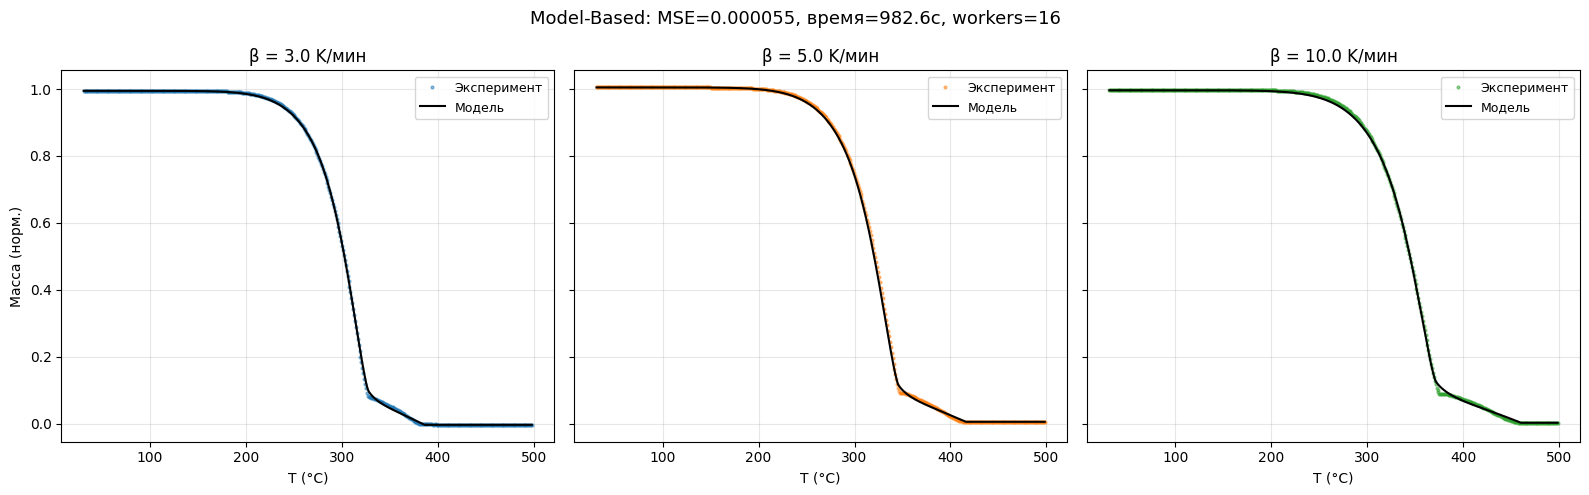

In [ ]:
# === 7. Визуализация: модель vs эксперимент ===
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pygmo_udp import _IntegrationTimeout

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for idx, (beta, exp_mass) in enumerate(zip(betas, all_exp_masses)):
    ax = axes[idx]

    # Модельная кривая
    y0 = np.zeros(num_species + num_reactions)
    y0[0] = 1.0
    deadline = time.perf_counter() + 5.0  # 5 сек для визуализации

    def ode_wrapper(T, y, _beta=beta, _bp=best_params):
        if time.perf_counter() > deadline:
            raise _IntegrationTimeout()
        return ode_function_numba(
            T, y, _beta, _bp, src_indices, tgt_indices, num_species, num_reactions
        )

    sol = solve_ivp(
        ode_wrapper,
        [exp_temperature[0], exp_temperature[-1]],
        y0,
        t_eval=exp_temperature,
        method=SOLVER_METHOD,
        rtol=1e-4,  # Точнее для визуализации
        atol=1e-6,
    )

    if sol.success:
        rates = sol.y[num_species:num_species + num_reactions, :]
        contributions = best_params[3 * num_reactions: 4 * num_reactions]
        int_sum = np.sum(contributions[:, np.newaxis] * rates, axis=0)
        int_sum = np.clip(int_sum, 0.0, 1.0)
        M0, Mfin = exp_mass[0], exp_mass[-1]
        model_mass = M0 - (M0 - Mfin) * int_sum
        model_mass = np.clip(model_mass, Mfin, M0)

        T_C = exp_temperature - 273.15
        ax.plot(T_C, exp_mass, "o", color=colors[idx], markersize=2, alpha=0.5, label="Эксперимент")
        ax.plot(T_C, model_mass, "-", color="black", linewidth=1.5, label="Модель")
        ax.set_title(f"β = {beta} K/мин")
        ax.set_xlabel("T (°C)")
        if idx == 0:
            ax.set_ylabel("Масса (норм.)")
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, "ODE failed", transform=ax.transAxes, ha="center")

fig.suptitle(f"Model-Based: MSE={result.fun:.6f}, время={t_total:.1f}с, workers={n_cpus}", fontsize=13)
plt.tight_layout()
plt.show()